1. Import Necessary Libraries

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
#from pmdarima import auto_arima
import matplotlib.pyplot as plt
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

2. Load and Preprocess the Data

In [4]:
def preprocess_data(data, drop_unused_col):
    
    # Convert 'date' to datetime
    data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y')
    
    # Set the date as the index
    #data.set_index("date", inplace=True)
    
    # For daily frequency
    #data = data.asfreq('D')
    
    # Drop irrelevant columns
    if(drop_unused_col):
        data = data.drop(columns=['pods', 'percentage of usage'], errors='ignore')
    
    # Add US holiday feature
    calendar = USFederalHolidayCalendar()
    holidays = calendar.holidays(start=data['date'].min(), end=data['date'].max())
    data['is_holiday'] = data['date'].isin(holidays).astype(int)
    
    # Scale the 'cpu used' column
    scaler = StandardScaler()
    data['cpu used'] = scaler.fit_transform(data[['cpu used']])
    
    return data

3. Model Fine-Tuning Functions

In [18]:
# Define a wrapper class for ARIMA/SARIMA to use with GridSearchCV
class ModelWrapper:
    def __init__(self, order, seasonal_order=None, is_seasonal=False):
        self.order = order
        self.seasonal_order = seasonal_order
        self.is_seasonal = is_seasonal
    
    def fit(self, X, y=None):
        if self.is_seasonal and self.seasonal_order:
            self.model = SARIMAX(X, order=self.order, seasonal_order=self.seasonal_order).fit(disp=False)
        else:
            self.model = ARIMA(X, order=self.order).fit()
        return self
    
    def predict(self, X):
        return self.model.forecast(steps=len(X))
    
    def score(self, X, y):
        aic = self.model.aic
        return -aic  # Using AIC for scoring (negative AIC for minimization)
    
    # Required for GridSearchCV compatibility
    def get_params(self, deep=True):
        return {
            'order': self.order,
            'seasonal_order': self.seasonal_order,
            'is_seasonal': self.is_seasonal
        }
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

In [ ]:
#ARIMA Fine-Tuning
# def tune_arima(data):
#     model = auto_arima(data, seasonal=False, trace=True, error_action="ignore", suppress_warnings=True)
#     return model.order

In [ ]:
#ARIMA Fine-Tuning
# def gridsearch_arima(data):
#     best_score = float('inf')
#     best_order = None
    
#     # Range of ARIMA parameters to search
#     p_values = range(0, 3)
#     d_values = range(0, 2)
#     q_values = range(0, 3)
    
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 try:
#                     model = ARIMA(data, order=(p, d, q)).fit()
#                     aic = model.aic
#                     if aic < best_score:
#                         best_score = aic
#                         best_order = (p, d, q)
#                 except:
#                     continue
#     return best_order

In [19]:
# Unified grid search function
def gridsearch_model(data, seasonal=True):
    #Define parameter ranges for SARIMA
    p_values = range(0, 3)
    d_values = range(0, 2)
    q_values = range(0, 3)
    P_values = range(0, 2)
    D_values = range(0, 2)
    Q_values = range(0, 2)
    seasonal_period = 12  # Monthly seasonality
    
    # Define parameter grids for ARIMA and SARIMA
    param_grid_arima = {
    'order': [(p, d, q) for p in p_values for d in d_values for q in q_values],
    'is_seasonal': [False] # ARIMA doesn't use seasonal_order
    }
    
    param_grid_sarima = {
    'order': [(p, d, q) for p in p_values for d in d_values for q in q_values],
    'seasonal_order': [(P, D, Q, seasonal_period) for P in P_values for D in D_values for Q in Q_values],
    'is_seasonal': [True] # SARIMA requires seasonal_order
    }
    
    param_grid = param_grid_sarima if seasonal else param_grid_arima
    wrapper = ModelWrapper(order=(0, 0, 0), is_seasonal=seasonal)
    
    grid_search = GridSearchCV(
        estimator=wrapper, 
        param_grid=param_grid, 
        cv=3, 
        scoring=lambda estimator, X: estimator.score(X, None)
    )
    grid_search.fit(data)
    
    best_params = grid_search.best_params_
    return best_params['order'], best_params.get('seasonal_order', None)

In [ ]:
#SARIMA Fine-Tuning
# def tune_sarima(data):
#     model = auto_arima(data, seasonal=True, m=12, trace=True, error_action="ignore", suppress_warnings=True)
#     return model.order, model.seasonal_order

In [ ]:
# def gridsearch_sarima(data):
#     best_score = float('inf')
#     best_order = None
#     best_seasonal_order = None
    
#     # Define parameter ranges for SARIMA
#     p_values = range(0, 3)
#     d_values = range(0, 2)
#     q_values = range(0, 3)
#     P_values = range(0, 2)
#     D_values = range(0, 2)
#     Q_values = range(0, 2)
#     seasonal_period = 12  # Monthly seasonality
    
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 for P in P_values:
#                     for D in D_values:
#                         for Q in Q_values:
#                             try:
#                                 model = SARIMAX(data, 
#                                                 order=(p, d, q), 
#                                                 seasonal_order=(P, D, Q, seasonal_period)).fit(disp=False)
#                                 aic = model.aic
#                                 if aic < best_score:
#                                     best_score = aic
#                                     best_order = (p, d, q)
#                                     best_seasonal_order = (P, D, Q, seasonal_period)
#                             except:
#                                 continue
#     return best_order, best_seasonal_order

In [7]:
#Prophet Hyperparameter Tuning
def tune_prophet(data):
    prophet_data = data.reset_index()[['date', 'cpu used', 'cpu requested', 'is_holiday']].rename(columns={'date': 'ds', 'cpu used': 'y'})
    
    best_params = {}
    best_error = float('inf')
    changepoint_prior_scale_values = [0.01, 0.1, 0.5]
    seasonality_prior_scale_values = [0.1, 1.0, 10.0]
    
    for changepoint_prior_scale in changepoint_prior_scale_values:
        for seasonality_prior_scale in seasonality_prior_scale_values:
            model = Prophet(changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale)
            model.add_regressor('cpu requested')
            model.add_regressor('is_holiday')
            model.add_country_holidays(country_name='US')
            model.fit(prophet_data)
            
            future = model.make_future_dataframe(periods=15)
            future['cpu requested'] = data['cpu requested'].iloc[-1]
            future['is_holiday'] = 0
            forecast = model.predict(future)['yhat'][-15:]
            error = mean_absolute_error(data['cpu used'].iloc[-15:], forecast)
            
            if error < best_error:
                best_error = error
                best_params = {
                    "changepoint_prior_scale": changepoint_prior_scale,
                    "seasonality_prior_scale": seasonality_prior_scale
                }
    return best_params


In [23]:
#Exponential Smoothing Hyperparameter Tuning
def tune_exponential_smoothing(data):
    best_params = {}
    best_error = float('inf')
    
    alpha_values = [0.2, 0.5, 0.8]
    beta_values = [0.2, 0.5, 0.8]
    gamma_values = [0.2, 0.5, 0.8]
    
    for alpha in alpha_values:
        for beta in beta_values:
            for gamma in gamma_values:
                try:
                    model = ExponentialSmoothing(data, seasonal='add', seasonal_periods=12).fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
                    forecast = model.forecast(15)
                    error = mean_absolute_error(data[-15:], forecast)
                    if error < best_error:
                        best_error = error
                        best_params = {"alpha": alpha, "beta": beta, "gamma": gamma}
                except:
                    continue
    return best_params


4. Model Training Functions

In [9]:
#ARIMA Model
def train_arima(data, order, periods):
    model = ARIMA(data, order=order).fit()
    print("=============ARIMA===============")
    print(model.summary().tables[1])
    forecast = model.forecast(steps=periods)
    return forecast

In [10]:
#SARIMA Model
def train_sarima(data, order, seasonal_order, periods):
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order).fit(disp=False)
    print("=============SARIMA===============")
    print(model.summary().tables[1])
    forecast = model.forecast(steps=periods)
    return forecast

In [ ]:
#Exponential Smoothing
# def train_exponential_smoothing(data):
#     model = ExponentialSmoothing(data, seasonal='add', seasonal_periods=12).fit()
#     forecast = model.forecast(15)
#     return forecast

In [11]:
#Exponential Smoothing Training
def train_exponential_smoothing(data, params, periods):
    model = ExponentialSmoothing(data, seasonal='add', seasonal_periods=12).fit(
        smoothing_level=params["alpha"], smoothing_slope=params["beta"], smoothing_seasonal=params["gamma"]
    )
    print("=============ETS===============")
    print(model.summary().tables[1])
    forecast = model.forecast(periods)
    return forecast

In [ ]:
#Prophet Model
# def train_prophet(data):
#     prophet_data = data.reset_index()[['date', 'cpu used', 'cpu requested', 'is_holiday']].rename(columns={'date': 'ds', 'cpu used': 'y'})
#     model = Prophet()
#     model.add_regressor('cpu requested')
#     model.add_regressor('is_holiday')
#     model.add_country_holidays(country_name='US')
#     model.fit(prophet_data)
#     future = model.make_future_dataframe(periods=15)
#     future['cpu requested'] = data['cpu requested'].iloc[-1]
#     future['is_holiday'] = 0
#     forecast = model.predict(future)['yhat'][-15:]
#     return forecast

In [12]:
#Prophet Model
def train_prophet(data, params, periods):
    prophet_data = data.reset_index()[['date', 'cpu used', 'cpu requested', 'is_holiday']].rename(columns={'date': 'ds', 'cpu used': 'y'})
    model = Prophet(changepoint_prior_scale=params["changepoint_prior_scale"], seasonality_prior_scale=params["seasonality_prior_scale"])
    model.add_regressor('cpu requested')
    model.add_regressor('is_holiday')
    model.add_country_holidays(country_name='US')
    model.fit(prophet_data)
    
    future = model.make_future_dataframe(periods=periods)
    future['cpu requested'] = data['cpu requested'].iloc[-1]
    future['is_holiday'] = 0
    forecast = model.predict(future)['yhat'][-periods:]
    return forecast

5. Hybrid Model

In [ ]:
# def hybrid_forecast(sarima_forecast, prophet_forecast, weight_sarima=0.5, weight_prophet=0.5):
#     return (weight_sarima * sarima_forecast) + (weight_prophet * prophet_forecast)

6. Error Evaluation

In [13]:
def calculate_errors(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    #rmse = root_mean_squared_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = 100 * np.mean(np.abs((actual - predicted) / actual))
    smape = 100 * (2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted))).mean()
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'sMAPE': smape}

7. Visualization

In [ ]:
# def visualize_predictions(actual, forecasts):
#     plt.figure(figsize=(12, 6))
#     plt.plot(actual.index, actual, label='Actual', color='black')
#     for model_name, forecast in forecasts.items():
#         plt.plot(range(len(actual), len(actual) + len(forecast)), forecast, label=model_name)
#     plt.legend()
#     plt.title('Actual vs Predicted CPU Usage')
#     plt.xlabel('Date')
#     plt.ylabel('CPU Usage')
#     plt.show()

In [14]:
#Actual vs Predicted Visualization
def visualize_predictions(actual, predictions, title='Actual vs Predicted Values'):
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual, label='Actual', color='black')
    for model, pred in predictions.items():
        plt.plot(range(len(actual), len(actual) + len(pred)), pred, label=model)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('CPU Used')
    plt.legend()
    plt.show()


In [15]:
#Dataset Trend Visualization
def visualize_dataset(data, title='Dataset Trend'):
    plt.figure(figsize=(12, 6))
    for namespace in data['namespace'].unique():
        ns_data = data[data['namespace'] == namespace]
        plt.plot(ns_data['date'], ns_data['cpu used'], label=namespace)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('CPU Used')
    plt.legend()
    plt.show()

8. Main Function

In [ ]:
# def main(file_path):
#     # Preprocess data
#     data, scaler = preprocess_data(file_path)
    
#     # Namespace-level forecasting
#     results = {}
#     for namespace in data['namespace'].unique():
#         ns_data = data[data['namespace'] == namespace]
#         ns_cpu_used = ns_data['cpu used']
        
#         # ARIMA
#         arima_order = tune_arima(ns_cpu_used)
#         arima_forecast = train_arima(ns_cpu_used, arima_order)
        
#         # SARIMA
#         sarima_order, sarima_seasonal_order = tune_sarima(ns_cpu_used)
#         sarima_forecast = train_sarima(ns_cpu_used, sarima_order, sarima_seasonal_order)
        
#         # Exponential Smoothing
#         exp_forecast = train_exponential_smoothing(ns_cpu_used)
        
#         # Prophet
#         prophet_forecast = train_prophet(ns_data)
        
#         # Hybrid Model
#         hybrid = hybrid_forecast(sarima_forecast, prophet_forecast)
        
#         # Error Evaluation
#         errors = {
#             'ARIMA': calculate_errors(ns_cpu_used[-15:], arima_forecast),
#             'SARIMA': calculate_errors(ns_cpu_used[-15:], sarima_forecast),
#             'Exponential Smoothing': calculate_errors(ns_cpu_used[-15:], exp_forecast),
#             'Prophet': calculate_errors(ns_cpu_used[-15:], prophet_forecast),
#             'Hybrid': calculate_errors(ns_cpu_used[-15:], hybrid)
#         }
        
#         # Collect results
#         results[namespace] = {
#             'forecasts': {
#                 'ARIMA': arima_forecast,
#                 'SARIMA': sarima_forecast,
#                 'Exponential Smoothing': exp_forecast,
#                 'Prophet': prophet_forecast,
#                 'Hybrid': hybrid
#             },
#             'errors': errors
#         }
    
#     # Visualization
#     for namespace, result in results.items():
#         visualize_predictions(data[data['namespace'] == namespace]['cpu used'], result['forecasts'])
    
#     return results

In [21]:
def main(file_path):
    """
    4.1 Read the file.
    4.2 Preprocess the data.
    4.3 Visualize trends for each namespace.
    4.4 Hyperparameter tuning for each namespace.
    4.5 Train models using the best hyperparameters and make predictions.
    4.6 Evaluate error rates for each model.
    4.7 Visualize actual vs predicted values for each namespace.
    4.8 Select and return the best model for each namespace.
    """
    # 4.1 Read the file
    print("Step 4.1: Reading the file...")
    data = pd.read_csv(file_path)
    data = preprocess_data(data, drop_unused_col=False)
    results = {}

    # Iterate through each namespace
    for namespace in data['namespace'].unique():
        print(f"\nProcessing Namespace: {namespace}")
        
        # Filter namespace-specific data
        ns_data = data[data['namespace'] == namespace].set_index('date')
        ns_cpu_used = ns_data['cpu used']
        
        # 4.3 Visualize trends for this namespace
        print(f"Step 4.3: Visualizing trends for namespace '{namespace}'...")
        visualize_dataset(data[data['namespace'] == namespace], f'Trend for Namespace: {namespace}')
        
        # 4.4 Hyperparameter tuning
        print("Step 4.4: Hyperparameter tuning...")
        #arima_params = gridsearch_arima(ns_cpu_used)
        #sarima_params, sarima_seasonal_params = gridsearch_sarima(ns_cpu_used)
        arima_params, _ = gridsearch_model(pd.to_numeric(ns_cpu_used, errors='coerce').dropna(), seasonal=False)
        sarima_params, sarima_seasonal_params = gridsearch_model(pd.to_numeric(ns_cpu_used, errors='coerce').dropna(), seasonal=True)
        prophet_params = tune_prophet(data[data['namespace'] == namespace])
        exp_params = tune_exponential_smoothing(ns_cpu_used)
        
        print(f"ARIMA Params: {arima_params}")
        print(f"SARIMA Params: {sarima_params} Seasonal Params: {sarima_seasonal_params}")
        print(f"Prophet Params: {prophet_params}")
        print(f"Exponential Smoothing Params: {exp_params}")
        
        # 4.5 Train models and predict
        print("Step 4.5: Training models and making predictions...")
        arima_pred = train_arima(ns_cpu_used, arima_params, 15)
        sarima_pred = train_sarima(ns_cpu_used, sarima_params, sarima_seasonal_params, 15)
        prophet_pred = train_prophet(data[data['namespace'] == namespace], prophet_params, 15)
        exp_pred = train_exponential_smoothing(ns_cpu_used, exp_params, 15)
        #hybrid_pred = (0.5 * sarima_pred) + (0.5 * prophet_pred)  # Example of weighted hybrid model
        
        # 4.6 Evaluate error rates
        print("Step 4.6: Evaluating error rates...")
        actual_values = ns_cpu_used[-15:]  # Last 15 actual values for comparison
        errors = {
            'ARIMA': calculate_errors(actual_values, arima_pred),
            'SARIMA': calculate_errors(actual_values, sarima_pred),
            'Prophet': calculate_errors(actual_values, prophet_pred),
            'Exponential Smoothing': calculate_errors(actual_values, exp_pred)
            #'Hybrid': calculate_errors(actual_values, hybrid_pred)
        }
        
        # Log error rates
        print(f"Error Rates for Namespace: {namespace}")
        for model, error in errors.items():
            print(f"{model}: {error}")
        
        # 4.7 Visualize actual vs predicted
        print("Step 4.7: Visualizing actual vs predicted values...")
        predictions = {
            'ARIMA': arima_pred,
            'SARIMA': sarima_pred,
            'Prophet': prophet_pred,
            'Exponential Smoothing': exp_pred
            #'Hybrid': hybrid_pred
        }
        visualize_predictions(actual_values, predictions, f'Actual vs Predicted for Namespace: {namespace}')
        
        # 4.8 Find the best model
        print("Step 4.8: Identifying the best model...")
        best_model = min(errors, key=lambda x: errors[x]['MAE'])  # Selecting the model with the lowest MAE
        print(f"Best Model for Namespace '{namespace}': {best_model}")
        
        # Store results
        results[namespace] = {
            'errors': errors,
            'best_model': best_model,
            'forecasts': predictions
        }
    
    print("\nAll namespaces processed. Summary of results:")
    for namespace, result in results.items():
        print(f"Namespace: {namespace} | Best Model: {result['best_model']}")
    return results

Step 4.1: Reading the file...

Processing Namespace: test-1
Step 4.3: Visualizing trends for namespace 'test-1'...


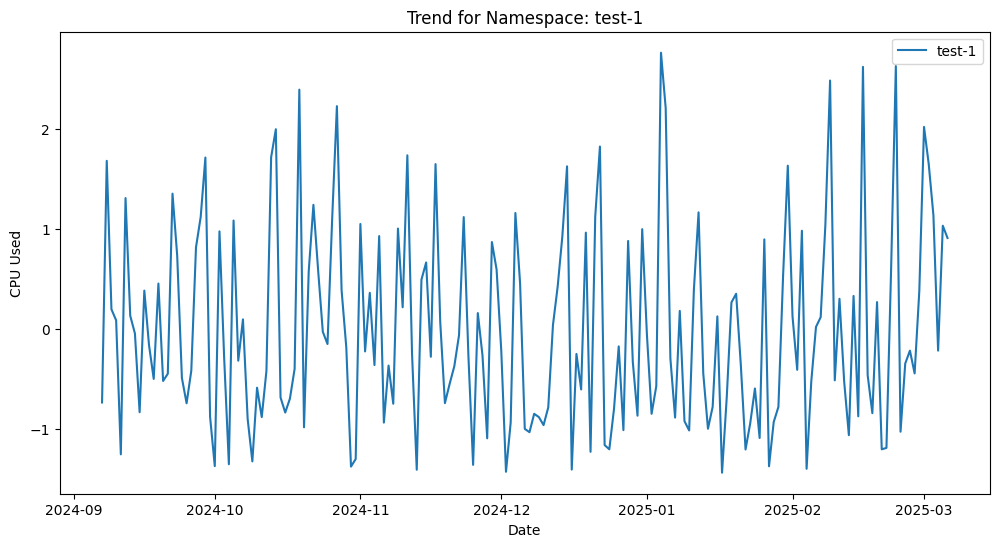

Step 4.4: Hyperparameter tuning...


c:\Users\Uttam Kumar\Learning\Time-series\codebase\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Uttam Kumar\Learning\Time-series\codebase\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Uttam Kumar\Learning\Time-series\codebase\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Uttam Kumar\Learning\Time-series\codebase\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users

ARIMA Params: (2, 0, 2)
SARIMA Params: (2, 0, 2) Seasonal Params: (0, 1, 1, 12)
Prophet Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}
Exponential Smoothing Params: {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.2}
Step 4.5: Training models and making predictions...


c:\Users\Uttam Kumar\Learning\Time-series\codebase\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Uttam Kumar\Learning\Time-series\codebase\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


=============ARIMA===============
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0104      0.075      0.138      0.890      -0.137       0.158
ar.L1          1.2443      0.008    157.145      0.000       1.229       1.260
ar.L2         -0.9998      0.006   -170.868      0.000      -1.011      -0.988
ma.L1         -1.2376      0.765     -1.618      0.106      -2.736       0.261
ma.L2          0.9993      1.227      0.815      0.415      -1.405       3.404
sigma2         0.8397      1.027      0.817      0.414      -1.173       2.853


12:03:42 - cmdstanpy - INFO - Chain [1] start processing
12:03:42 - cmdstanpy - INFO - Chain [1] done processing


=============SARIMA===============
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3792      0.377      1.006      0.314      -0.360       1.118
ar.L2         -0.1591      0.366     -0.435      0.664      -0.876       0.558
ma.L1         -0.2575      0.382     -0.675      0.500      -1.006       0.491
ma.L2         -0.0833      0.366     -0.227      0.820      -0.801       0.634
ma.S.L12      -0.9993     17.485     -0.057      0.954     -35.268      33.270
sigma2         0.9744     17.027      0.057      0.954     -32.399      34.347


c:\Users\Uttam Kumar\Learning\Time-series\codebase\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Uttam Kumar\AppData\Local\Temp\ipykernel_23284\3795196821.py:3: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(data, seasonal='add', seasonal_periods=12).fit(
C:\Users\Uttam Kumar\AppData\Local\Temp\ipykernel_23284\1689527639.py:5: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = 100 * np.mean(np.abs((actual - predicted) / actual))


=============ETS===============
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8000000                alpha                False
smoothing_seasonal            0.2000000                gamma                False
initial_level                -0.2772575                  l.0                 True
initial_seasons.0            -0.4568196                  s.0                 True
initial_seasons.1             0.5566736                  s.1                 True
initial_seasons.2            -0.1656347                  s.2                 True
initial_seasons.3             0.1565023                  s.3                 True
initial_seasons.4            -0.1332235                  s.4                 True
initial_seasons.5             0.1854597                  s.5                 True
initial_seasons.6            -0.0263369                  s.6      

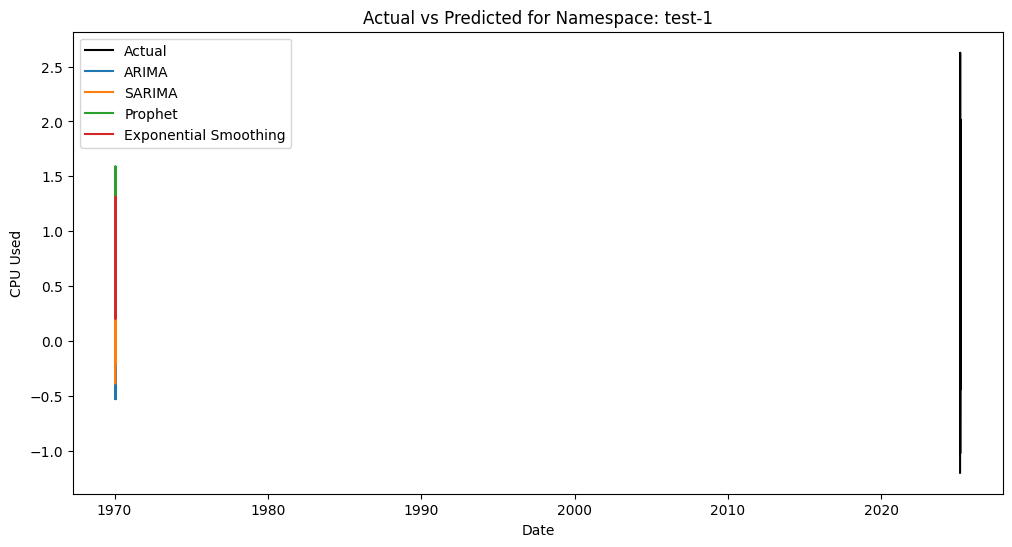

Step 4.8: Identifying the best model...
Best Model for Namespace 'test-1': ARIMA

All namespaces processed. Summary of results:
Namespace: test-1 | Best Model: ARIMA


In [22]:
# Example Usage
results = main('./data/test-1_cpu_usage_data.csv')